In [ ]:
!pip install --upgrade mxnet==1.6.0
!pip install gluonts 

     |████████████████████████████████| 68.7MB 61kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 430kB 2.7MB/s 
     |████████████████████████████████| 92kB 6.6MB/s 
     |████████████████████████████████| 9.2MB 7.1MB/s 
     |████████████████████████████████| 10.1MB 47.1MB/s 
     |████████████████████████████████| 194kB 47.9MB/s 
  Created wheel for holidays: filename=holidays-0.9.12-cp36-none-any.whl size=47611 sha256=4d27d6ba0251bdc36c46671f96caace1e897514cb4d4eb7367db8a76d211c3e4
  Stored in directory: /root/.cache/pip/wheels/1f/fd/3a/f29866dc23dada18f25e9837477c82bbd7952aeef86fa46f11
  Created wheel for ujson: filename=ujson-1.35-cp36-cp36m-linux_x86_64.whl size=68020 sha256=31ea042fdf9ca93dcd3800bb29dce677f07c51a7066da975938237dad39abf82
  Stored in directory: /root/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
Successfully

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
import numpy as np

mpl.rcParams['figure.figsize'] = [10, 8]
mpl.rcParams['axes.grid'] = False

In [ ]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')

In [ ]:
df.sample(10)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
3280,2016-02-03 11:40:00,340,0,22.166667,43.560000,21.700000,42.663333,21.884444,43.893889,22.390000,42.090000,19.100000,55.290000,5.333333,75.496667,18.700000,35.777222,20.260000,43.537778,18.500000,46.345000,5.700000,759.933333,69.333333,7.333333,36.333333,0.400000,41.514064,41.514064
1994,2016-01-25 13:20:00,60,0,20.290000,43.590000,19.500000,43.090000,20.200000,44.400000,18.200000,45.000000,18.220000,47.938889,11.226667,79.893333,17.890000,40.925556,19.208889,46.865556,16.823333,48.933333,12.233333,762.700000,58.666667,5.666667,40.000000,4.233333,16.875162,16.875162
12371,2016-04-06 14:50:00,100,0,21.890000,40.966667,20.500000,42.030000,23.000000,38.500000,21.600000,40.833333,20.533333,45.400000,12.900714,25.927083,21.023810,34.806667,22.730000,41.433333,20.790000,39.290000,11.133333,752.283333,71.666667,9.000000,40.000000,6.166667,26.145702,26.145702
15704,2016-04-29 18:20:00,120,10,22.760000,39.493333,21.200000,37.796667,23.100000,35.466667,20.000000,39.626667,19.100000,42.860000,10.530000,30.666667,19.200000,34.240000,21.290000,40.566667,18.790000,37.672500,9.333333,755.500000,78.333333,4.000000,40.000000,5.700000,26.900513,26.900513
373,2016-01-14 07:10:00,360,20,18.390000,42.863333,17.790000,41.966667,19.760000,43.363333,18.000000,42.590000,17.290000,61.733333,3.790000,88.623333,18.000000,43.656667,18.823333,50.730000,16.790000,48.466667,3.950000,749.400000,89.500000,8.833333,26.666667,2.416667,11.523321,11.523321
2560,2016-01-29 11:40:00,10,0,18.000000,43.700000,17.166667,44.290000,19.100000,42.000000,16.890000,44.090000,16.688889,50.280000,7.660000,83.856667,17.000000,39.290000,17.127778,45.790000,16.290000,43.590000,7.200000,763.833333,82.000000,8.666667,40.000000,4.333333,2.874300,2.874300
9538,2016-03-17 22:40:00,70,20,22.790000,34.260000,19.760000,36.860000,21.600000,35.200000,23.000000,33.126667,19.290000,77.863333,3.400000,51.423333,21.100000,26.230000,23.166667,35.656667,19.890000,36.700000,2.800000,764.433333,85.666667,2.000000,61.333333,0.633333,14.677037,14.677037
19184,2016-05-23 22:20:00,70,30,24.890000,44.790000,22.760000,45.326667,25.760000,42.163333,24.356667,44.700000,23.700000,58.067143,11.100000,29.930000,23.500000,38.178000,25.100000,47.266667,22.700000,42.566667,11.233333,759.333333,82.000000,3.666667,40.000000,8.200000,29.468659,29.468659
14705,2016-04-22 19:50:00,90,0,23.200000,39.933333,21.600000,38.363333,26.033333,35.590000,22.700000,35.212857,20.790000,43.900000,12.360000,10.393333,21.671429,31.071429,23.890000,40.833333,20.500000,35.826667,12.383333,756.883333,60.500000,4.833333,40.000000,4.866667,12.757332,12.757332
5200,2016-02-16 19:40:00,120,30,21.790000,39.026667,19.760000,36.766667,21.066667,36.900000,19.390000,34.200000,19.600000,39.126667,-1.845000,65.150000,20.760000,25.390000,22.600000,33.223333,18.290000,38.530000,0.233333,770.000000,72.666667,1.000000,32.666667,-4.200000,41.323879,41.323879


In [ ]:
color_list = [
              "blue",
              "orange",
              "green",
              "red",
              "purple",
              "brown",
              "pink",
              "gray",
              "olive",
              "cyan"
]

date_key = "date"

def Visualization(data):
  time_data = data[date_key]
  features = list(df.select_dtypes(include=[np.number]).columns.values)
  feature_size = len(features)
  fig, axes = plt.subplots(
      nrows =int(np.ceil(feature_size/2)), ncols=2, figsize=(14, feature_size*2), dpi=100, facecolor="w", edgecolor="k"
  )
  for i in range(feature_size):
    key = features[i]
    c = color_list[i% (len(color_list))]
    t_data = data[key]
    t_data.index = time_data
    t_data.head()
    ax = t_data.plot(
        ax=axes[i//2, i%2],
        color=c,
        title="{}".format(key),
        rot=25
    )
    ax.legend([key])
    plt.tight_layout()


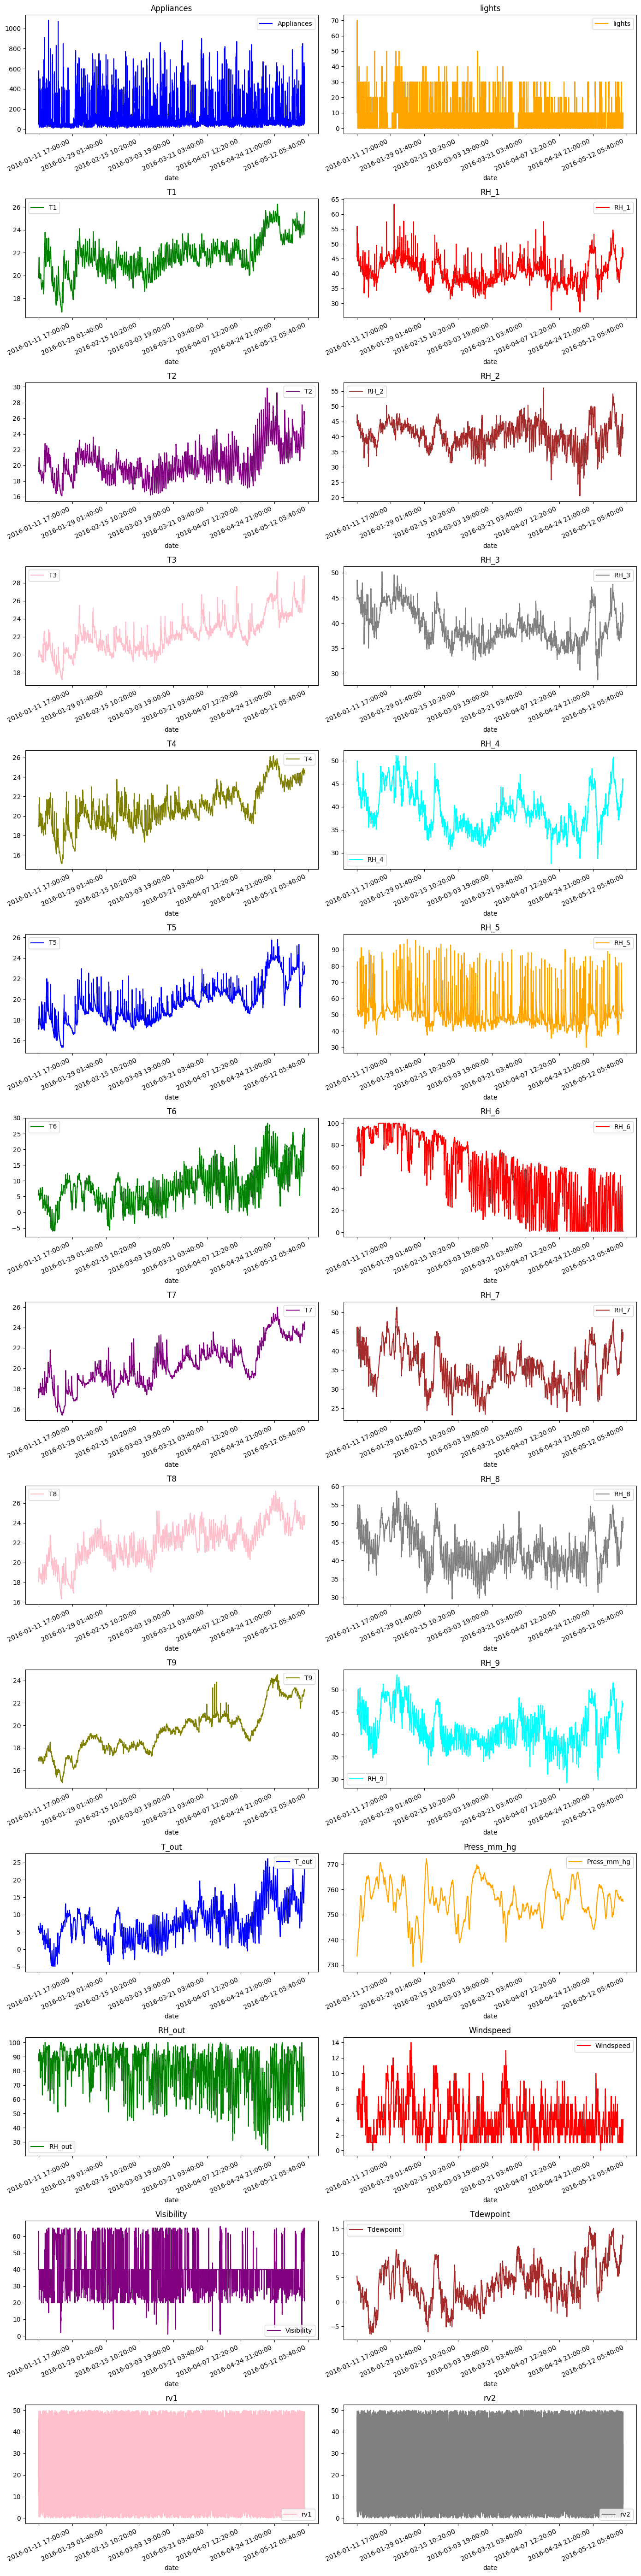

In [ ]:
Visualization(df)

In [ ]:
df_input = df[['date','Appliances','T_out','Press_mm_hg','RH_out','Windspeed','Tdewpoint','Visibility']]

In [ ]:
df_input = df_input.set_index('date')

In [ ]:
train_time = "2016-05-10 00:00:00"
prediction_length = 144

In [ ]:
estimator = DeepAREstimator(freq="10min",
                            context_length=720,
                            prediction_length=prediction_length,
                            num_layers=2,
                            num_cells=128,
                            cell_type='lstm',
                            trainer=Trainer(epochs=8))

In [ ]:
from gluonts.dataset.common import ListDataset

training_data = ListDataset(
    [{"start":df_input.index[0], "target": df_input.Appliances[:train_time]}],
    freq = "10min"
)
#We are doing univariate analysis "target": df_input.Appliances[:train_time]

In [ ]:
predictor = estimator.train(training_data=training_data)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [03:39<00:00,  4.39s/it, epoch=8/8, avg_epoch_loss=4.38]


In [ ]:
test_data = ListDataset(
    [
     {"start": df_input.index[0], "target": df_input.Appliances[:"2016-05-11 00:00:00"]},
     {"start": df_input.index[0], "target": df_input.Appliances[:"2016-05-15 00:00:00"]}
    ],
    freq = "10min"
)

In [ ]:
from gluonts.evaluation.backtest import  make_evaluation_predictions

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset = test_data,
    predictor = predictor,
    num_samples = 100
)

In [ ]:
forecast = list(forecast_it)
tss = list(ts_it)

In [ ]:
forecast_entry = forecast[0]

In [ ]:
forecast_entry

gluonts.model.forecast.SampleForecast(freq="10min", info=None, item_id=None, samples=numpy.array([[64.08343505859375, 59.75810623168945, 51.35950469970703, 61.694950103759766, 57.97541809082031, 71.63935089111328, 66.6135025024414, 66.99098205566406, 71.89016723632812, 59.796810150146484, 63.12052536010742, 75.28492736816406, 59.178733825683594, 52.170108795166016, 47.042205810546875, 62.39986801147461, 56.82294464111328, 68.30265045166016, 64.34640502929688, 89.95765686035156, 120.64598846435547, 96.50589752197266, 112.3947982788086, 92.17048645019531, 85.70433807373047, 100.78169250488281, 45.267364501953125, 69.62727355957031, 44.570980072021484, 47.36465072631836, 70.82235717773438, 85.06800842285156, 97.91944885253906, 101.29218292236328, 165.79092407226562, 152.6090087890625, 133.93524169921875, 147.473388671875, 155.1438751220703, 156.2068328857422, 210.44375610351562, 305.32470703125, 323.39422607421875, 66.34527587890625, 75.2742691040039, 104.82593536376953, 94.46484375, 112.

In [ ]:
def plot_prob_forecast(ts_entry, forecast_entry):
  plot_length = prediction_length
  prediction_intervals = (80.0, 95.0)
  legend = ["observations","median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

  fig, ax = plt.subplots(1,1,figsize=(10,7))
  ts_entry[-plot_length:].plot(ax=ax)
  forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
  plt.grid(which="both")
  plt.legend(legend, loc="upper left")
  plt.show()

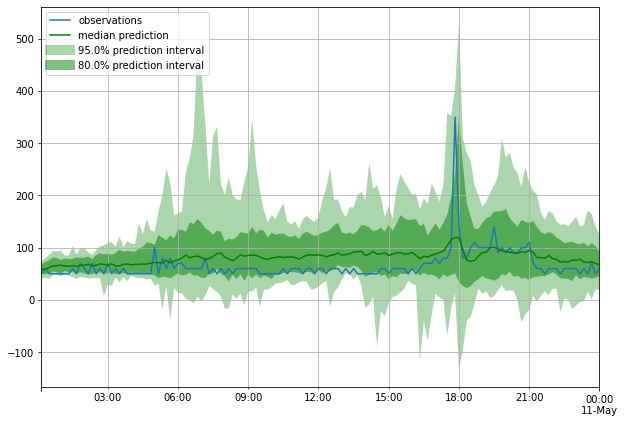

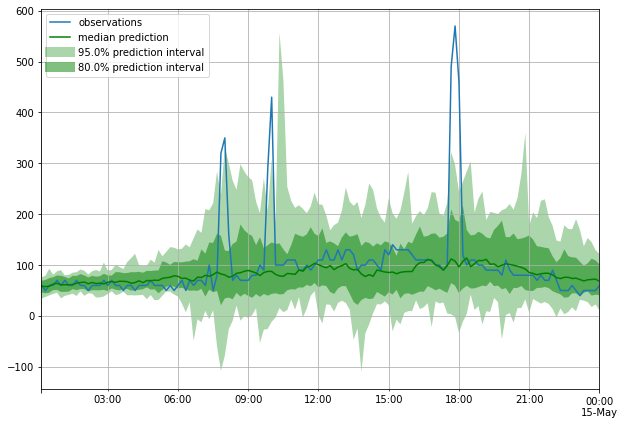

In [ ]:
plot_prob_forecast(tss[0], forecast[0])
plot_prob_forecast(tss[1], forecast[1])

In [ ]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1,0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecast), num_series = len(test_data))

Running evaluation: 100%|██████████| 2/2 [00:00<00:00, 39.24it/s]WARNING:root:multiple 10 does not divide base seasonality 1.Falling back to seasonality 1



In [ ]:
agg_metrics

{'Coverage[0.1]': 0.13541666666666666,
 'Coverage[0.5]': 0.7048611111111112,
 'Coverage[0.9]': 0.9618055555555556,
 'MAE_Coverage': 0.10069444444444446,
 'MAPE': 0.2820978756311614,
 'MASE': 0.860853040219848,
 'MSE': 3293.5465494791665,
 'MSIS': 10.47187297107801,
 'ND': 0.3104136618065015,
 'NRMSE': 0.6927139783414764,
 'OWA': nan,
 'QuantileLoss[0.1]': 2271.409136962891,
 'QuantileLoss[0.5]': 7406.47017288208,
 'QuantileLoss[0.9]': 6495.948291015624,
 'RMSE': 57.389428900095936,
 'abs_error': 7406.469970703125,
 'abs_target_mean': 82.84722222222223,
 'abs_target_sum': 23860.0,
 'mean_wQuantileLoss': 0.22595456273904155,
 'sMAPE': 0.2611201640588261,
 'seasonal_error': 29.8875442944757,
 'wQuantileLoss[0.1]': 0.09519736533792501,
 'wQuantileLoss[0.5]': 0.3104136702800536,
 'wQuantileLoss[0.9]': 0.272252652599146}

In [ ]:
item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,1025.548828,3144.98999,9510.0,66.041667,29.977297,0.728558,0.354905,0.294959,NaN,6.003583,758.374631,0.229167,3144.990074,0.840278,2000.014618,0.993056
1,NaN,5561.544271,4261.47998,14350.0,99.652778,29.797792,0.993148,0.209290,0.227282,NaN,14.940163,1513.034506,0.041667,4261.480099,0.569444,4495.933673,0.930556


Help is available on videos: https://www.youtube.com/watch?v=xcbj0RE3kfI&feature=youtu.be